In [14]:
import sys
import os
import cv2
import math

import numpy as np
print("numpy v%s"%np.__version__)

import pandas as pd
import liblas

import warnings
warnings.filterwarnings('ignore')


import os
import json
import cv2
import six
import numpy as np
import math
from moviepy.editor import ImageSequenceClip, clips_array, TextClip, CompositeVideoClip

from tracklets.python.generate_tracklet import Tracklet, TrackletCollection

from loaders import handle_data_folder
# from centroids import get_first_centroid_for
from unwrapper import *
from image_utils import array_to_image


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['savefig.dpi'] = 320
mpl.rcParams['figure.dpi'] = 320

numpy v1.12.1


In [53]:
def load_center_json(filepath):
    with open(filepath, 'r') as f:
        return json.load(f)

def draw_centers(img, centers, d=10):
    img = np.copy(img)
    r = 200 / d
    for center in centers:
        cv2.circle(img, (int(math.floor(center[0])), int(math.floor(center[1]))), int(r), (255, 0, 0), 2)
    return img


def load_image(image_filepath):
    with open(image_filepath, 'r') as f:
        return np.load(f)
    
def parse_image_name(image_name):
    _, rot_str, display_type, timestamp_str = image_name.split('_')
    timestamp_str = timestamp_str.replace("s", "").replace(".png", "")
    rot = float(rot_str.replace("rot", ""))
    return rot, display_type, timestamp_str

def wrap_point(img_x, img_y, d, unrotation_deg=0.0):
    # UNSHIFT COORDINATES
    img_x = np.trunc(-img_x - X_MIN).astype(np.int32)
    img_y = np.trunc(img_y + Y_MIN).astype(np.int32)

    angle_rad = H_RES_RAD * img_x
    z = np.tan(-V_RES_RAD * img_y) * d
    x = d * np.cos(angle_rad)
    y = d * np.sin(angle_rad)

    theta = unrotation_deg * float(D2R)
    if theta != 0:
        x, y, z = rotate_around_center(x, y, z, -theta).T
    else:
        x, y, z = [[x], [y], [z]]
    return x, y, z


In [250]:
center_json = load_center_json("center_without_false_positives_json.js")
#center_json = load_center_json("data_3_14_centers_json.js")
base_folder = "/Users/max/Desktop/carchallenge/training_data/round_1_test/19_f2/unlabelled"
#base_folder = "/Users/max/Desktop/carchallenge/training_data/data_3/14/labelled"

points_filepath = "/Users/max/Desktop/carchallenge/car_out/round_1_test/19_f2"
#points_filepath = "/Users/max/Desktop/carchallenge/car_out/round_1_test/19_f2"


In [251]:
data = handle_data_folder(points_filepath)

df_points = data["points"]
o_points = df_points

Loading csv from '/Users/max/Desktop/carchallenge/car_out/round_1_test/19_f2/points.csv'


In [252]:
image_names = sorted([key for key in six.iterkeys(center_json)])

image_frames = {}
xyz_point_dict = {}
tracklets = []

In [263]:
image_frames = {}
xyz_point_dict = {}
tracklets = []

for image_name in image_names:
    rot, display_type, timestamp_str = parse_image_name(image_name)

    if rot not in xyz_point_dict:
        xyz_point_dict[rot] = []

    img_xy_points = center_json[image_name]

    #points = df_points.get_group(int(timestamp_str))
    #points = calculate_distance(points, d_range=(0.0, 40.0))

    #x_points, y_points = unwrap_point(points['x'], points['y'], points['z'], points['map_distance'], rotation_deg=rot)
    #img_distance = array_to_image(points['map_distance'], [x_points, y_points], IMG_DIMENSIONS)
    # for img_x, img_y in img_xy_points:
    #if len(img_xy_points) > 0:
    #    if img_xy_points[0] is not None:
    #        if not isinstance(img_xy_points[0], list):
    #            img_xy_points = [img_xy_points]
            #if isintance(img_xy_points[0], list):
            #    if len(img_xy_points[0]) == 1:
                    
    if len(img_xy_points) > 0:
        img_x, img_y, img_d = img_xy_points[0]
        
        #image_filepath = os.path.join(base_folder, image_name)
        #img = cv2.imread(image_filepath)
        d = img_d #(float(np.mean(img[img_y][img_x]))/255.0)*40.0
        
        img_x = img_x / 1.5
        img_y = img_y / (1.5 * 1.2)
        
        #d = img_distance[int(img_y)][int(img_y)]

        xyz_point = np.array(wrap_point(img_x, img_y, d, unrotation_deg=rot)).flatten()

        xyz_point_dict[rot].append(list(xyz_point))
    else:
       # if len(xyz_point_dict[rot]) > 0:
           # xyz_point_dict[rot].append(xyz_point_dict[rot][-1])
        #else: 
        xyz_point_dict[rot].append(None)

In [268]:
print(len(xyz_point_dict))
print(len(xyz_point_dict[0]))
print(xyz_point_dict.values()[0][0])
#xyz_point_dict

1
268
None


In [281]:
#xyz_point_averages = np.average(xyz_point_dict.values(), axis=0)
#xyz_point_averages.shape
num_arr = len(xyz_point_dict.values())
num_in_arr = len(xyz_point_dict.values()[0])
xyz_point_averages = None
xyz_point_averages = []*num_in_arr
null_votes = [0]*num_in_arr
print(num_arr, num_in_arr, len(xyz_point_averages))


#for i in range(num_in_arr):
    #for xyz_point_arr in xyz_point_arrs:
#    xyz_point_averages[i].append([x, y, z])
    
for rot, xyz_point_arr in xyz_point_dict.items():
    #if rot != 0.0:
    #    pass
    #print(len(xyz_point_arr), xyz_point_arr[0])
    for i in range(num_in_arr):
        if len(xyz_point_averages) <= i:
            xyz_point_averages.append([])
            
        xyz_point = xyz_point_arr[i]
        if xyz_point is None or len(xyz_point) < 3:
            null_votes[i] += 1
        elif xyz_point[0]==0 and xyz_point[1] == 0 and xyz_point[2] == 0:
            null_votes[i] += 1
        else:
            x, y, z = xyz_point
            xyz_point_averages[i].append([x, y, z])
            
        #print(i, len(xyz_point_averages[i]))#, xyz_point_averages)
print(len(xyz_point_averages))

if False:
    for i in range(len(xyz_point_averages)):
        if null_votes[i] > 0 and float(len(xyz_point_averages[i]))/float(null_votes[i]) >= 0.3:
            xyz_point_averages[i] = np.mean(xyz_point_averages[i], axis=0)
        else:
            xyz_point_averages[i] = None

#print(xyz_point_averages)
    
#for pt in xyz_point_averages:
#    print(len(pt))
#for i in range(len(xyz_point_arr)):
    
#print(null_votes)
print(xyz_point_averages)
        

(1, 268, 0)
268
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [[2.9380909452737116, 2.3538547062050079, -0.1314664263218738]], [], [[3.1541233470383196, 3.0565581654250673, -0.15337749737551945]], [[2.2412324805120063, 2.6241460773648133, -0.301921662363973]], [[6.7236974415360198, 7.8724382320944395, -0.90576498709191899]], [[6.6218232378763817, 7.7531588649414926, -0.89204127516628384]], [[7.3349426634938384, 8.5881144350121144, -0.98810725864572968]], [[5.8627986482844081, 8.3419186874708267, -0.89204127516628384]], [[10.181189892493395, 17.849526022180868, -0.71758757700689446]], [[-5.3216172345966175, 7.5718954240119825, -0.

In [289]:
NUM_IMAGES = 646
#NUM_IMAGES = 320
tracklets = []
rot = None
#xyz_point_averages = xyz_point_dict.values()[0]
#for rot, xyz_points in six.iteritems(xyz_point_dict):
xyz_points = xyz_point_averages
print(rot, len(xyz_points))

img_have = len(xyz_points)
img_need = float(NUM_IMAGES)/len(xyz_points)

current_img_need = img_need

tc = TrackletCollection()
tracklet = None

pose = None
start_frame = 0
for xyz_point in xyz_points:
    if len(xyz_point) == 0:
        xyz_point = None
        
    if xyz_point is None:
        pose = None
        if tracklet is not None:
            print(rot, len(tracklet.poses))
            tc.tracklets.append(tracklet)
            tracklet = None
    else:
        if pose is None:
            tracklet = Tracklet(object_type="Car", l=4.5, w=4.52, h=1.39)
            tracklet.first_frame = start_frame
            print("start_frame: %s"%start_frame)
            
        xyz_point = xyz_point[0]
        pose = {
            "tx": xyz_point[0],
            "ty": xyz_point[1],
            "tz": xyz_point[2],
            "rx": 0,
            "ry": 0,
            "rz": 0
        }
        
    while current_img_need >= 1.0:
        current_img_need -= 1.0
        if pose is None:
            start_frame += 1
        else:
            tracklet.poses.append(pose)

    if current_img_need < 1:
        current_img_need += img_need
        
        
#if len(tracklet.poses) < NUM_IMAGES:
#    tracklet.poses.append(tracklet.poses[-1])

if tracklet is not None:
    print("how is the tracklet not null at the end")
    if len(tc.tracklets) > 0:
        tc.tracklets.append(tracklet)
    elif tc.tracklets[-1] != tracklet:
        tc.tracklets.append(tracklet)

longest_tracklet = tc.tracklets[0]
for tracklet in tc.tracklets:
    if len(tracklet.poses) > len(longest_tracklet.poses):
        longest_tracklet = tracklet

#tc.tracklets = [longest_tracklet]

print(len(tc.tracklets))


#tc.write_xml("output_data_3_14_tracklets.xml")
tc.write_xml("output_tracklets.xml")


(None, 268)
start_frame: 245
(None, 3)
start_frame: 247
(None, 27)
start_frame: 541
(None, 31)
3


In [238]:
path = "/Users/max/Desktop/carchallenge/training_data/round_1_test/19_f2/unlabelled/"
image_paths = sorted([x for x in os.listdir(path) if "unwrapped_rot0.0_intensity" in x and x.endswith("png")])
images = [cv2.imread(image_filepath, 0) for image_filepath in image_paths]

In [236]:
labeled_images = []
for tracklet, xyz_point in zip(tracklets, xyz_points):
    if len(tracklet.poses) > 0:
        pose = tracklet.poses[0]
        pose["tx"]
        pose["ty"]
        pose["tz"]
    continue

final_clip = ImageSequenceClip(images, fps=13)
final_clip.write_videofile("results_output_votes.mp4", codec='mpeg4')

AttributeError: 'NoneType' object has no attribute 'shape'

In [195]:
print(len(tracklets))


646


In [43]:
img_path = "/Users/max/Desktop/carchallenge/training_data/round_1_test/19_f2/unlabelled/unwrapped_rot0.0_distance_s1490993844094312000.png"
img = cv2.imread(img_path)

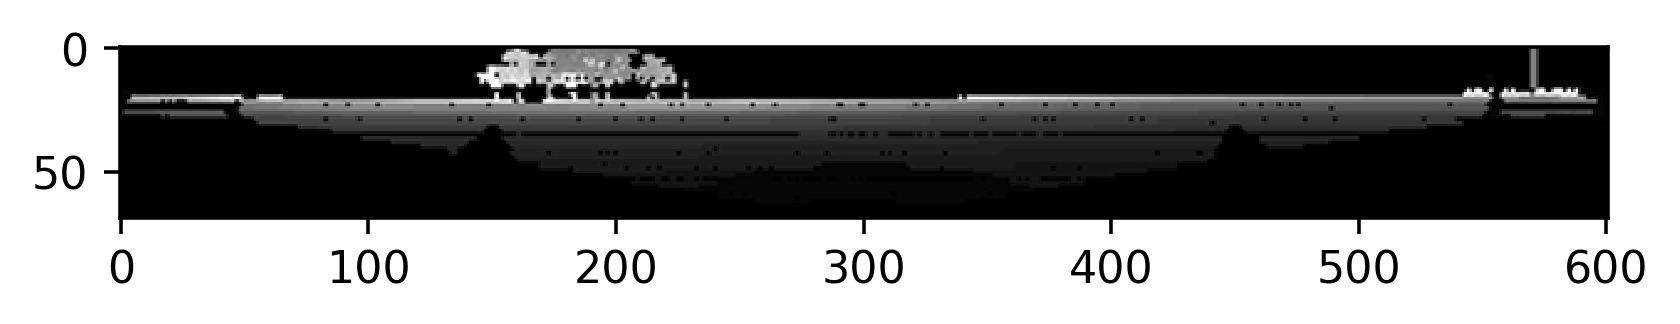

In [17]:
plt.imshow(img)

In [20]:
np.max(img)

255